### Introduction to Recurrent Neural Networks (RNNs)

#### Recurrent Neural Networks (RNNs) are a type of neural network specifically designed to handle sequential data.
#### Unlike traditional feedforward networks, RNNs contain loops that enable information to be retained,
#### making them well-suited for tasks involving time series, natural language processing, or any data with temporal relationships.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights and biases
        self.hidden_dim = hidden_dim
        self.W_input_hidden = np.random.randn(hidden_dim, input_dim) * 0.01
        self.W_hidden_hidden = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_hidden_output = np.random.randn(output_dim, hidden_dim) * 0.01
        self.bias_hidden = np.zeros((hidden_dim, 1))
        self.bias_output = np.zeros((output_dim, 1))

    def forward(self, input_sequence):
        # Initialize the hidden state to zeros
        h = np.zeros((self.hidden_dim, 1))

        # Store inputs and hidden states for backpropagation
        self.inputs = input_sequence
        self.hidden_states = {0: h}

        # Iterate through the input sequence
        for t, input_t in enumerate(input_sequence):
            # Compute the hidden state for the current time step
            h = np.tanh(np.dot(self.W_input_hidden, input_t) + 
                        np.dot(self.W_hidden_hidden, h) + 
                        self.bias_hidden)
            
            # Store the hidden state
            self.hidden_states[t + 1] = h

        # Compute the final output
        output = np.dot(self.W_hidden_output, h) + self.bias_output

        return output, h


### RNN Architecture

#### The fundamental concept of RNNs lies in their ability to preserve a hidden state, which serves as a memory of past inputs.
#### This hidden state is updated at each time step, enabling the network to recognize and leverage patterns over extended sequences.

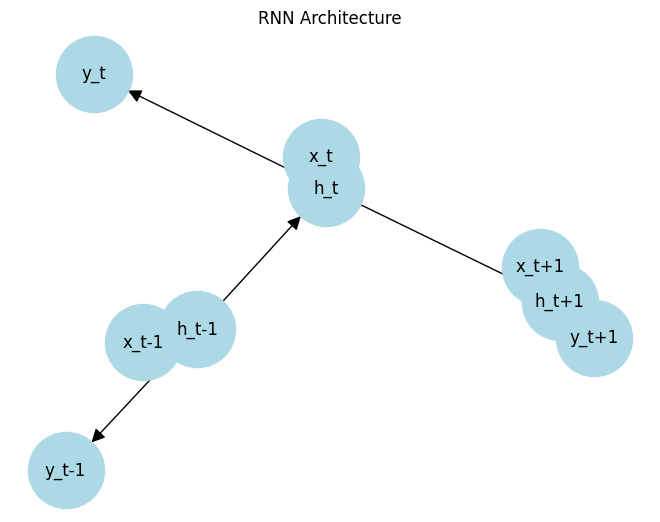

In [4]:

def draw_rnn():
    # Create a directed graph
    rnn_graph = nx.DiGraph()

    # Add edges representing the RNN connections
    rnn_graph.add_edges_from([
        ('x_t', 'h_t'), 
        ('h_t-1', 'h_t'), 
        ('h_t', 'h_t+1'), 
        ('h_t', 'y_t'), 
        ('x_t-1', 'h_t-1'), 
        ('h_t-1', 'y_t-1'), 
        ('x_t+1', 'h_t+1'), 
        ('h_t+1', 'y_t+1')
    ])

    # Define positions for the nodes using a spring layout
    pos = nx.spring_layout(rnn_graph)

    # Draw the graph with labels, node color, size, and arrows
    nx.draw(rnn_graph, pos, with_labels=True, node_color='lightblue',
            node_size=3000, arrowsize=20)

    # Add title and remove axis
    plt.title("RNN Architecture")
    plt.axis('off')

    # Display the plot
    plt.show()

# Call the function to draw the RNN
draw_rnn()

### Implementing the Forward Pass

#### In an RNN, the forward pass entails processing each input in the sequence while updating the hidden state at each step.
#### We'll use NumPy to efficiently handle the required matrix operations.

In [5]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim
        self.W_input_hidden = np.random.randn(hidden_dim, input_dim) * 0.01
        self.W_hidden_hidden = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_hidden_output = np.random.randn(output_dim, hidden_dim) * 0.01
        self.bias_hidden = np.zeros((hidden_dim, 1))
        self.bias_output = np.zeros((output_dim, 1))

    def forward(self, input_sequence):
        # Initialize hidden state
        hidden_state = np.zeros((self.hidden_dim, 1))
        outputs = []

        # Process each input in the sequence
        for input_t in input_sequence:
            hidden_state = np.tanh(np.dot(self.W_input_hidden, input_t) + 
                                   np.dot(self.W_hidden_hidden, hidden_state) + 
                                   self.bias_hidden)
            output_t = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            outputs.append(output_t)

        # Return the list of outputs and the final hidden state
        return outputs, hidden_state

# Example usage
rnn = SimpleRNN(input_dim=10, hidden_dim=20, output_dim=5)
inputs = [np.random.rand(10, 1) for _ in range(5)]  # 5 time steps with input dimension 10

# Perform forward pass
outputs, final_hidden_state = rnn.forward(inputs)

# Display results
print(f"Number of outputs: {len(outputs)}")
print(f"Shape of final output: {outputs[-1].shape}")
print(f"Shape of final hidden state: {final_hidden_state.shape}")

Number of outputs: 5
Shape of final output: (5, 1)
Shape of final hidden state: (20, 1)


### Backpropagation Through Time (BPTT).

#### Backpropagation Through Timeis the algorithm used to train RNNs.
#### It works by unrolling the network over time and using the chain rule to calculate gradients.
#### This process can become computationally intensive when dealing with long sequences.

In [6]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.W_input_hidden = np.random.randn(hidden_dim, input_dim) * 0.01
        self.W_hidden_hidden = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_hidden_output = np.random.randn(output_dim, hidden_dim) * 0.01
        self.bias_hidden = np.zeros((hidden_dim, 1))
        self.bias_output = np.zeros((output_dim, 1))

    def forward(self, input_sequence):
        # Initialize hidden state
        hidden_state = np.zeros((self.hidden_dim, 1))
        outputs = []
        hidden_states = [hidden_state]

        # Process each input in the sequence
        for input_t in input_sequence:
            hidden_state = np.tanh(np.dot(self.W_input_hidden, input_t) +
                                   np.dot(self.W_hidden_hidden, hidden_state) +
                                   self.bias_hidden)
            output_t = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            outputs.append(output_t)
            hidden_states.append(hidden_state)

        return outputs, hidden_states

    def compute_loss(self, predictions, targets):
        # Mean squared error
        return np.sum((np.array(predictions) - np.array(targets)) ** 2) / len(targets)

    def bptt(self, dh_next, cache, targets):
        inputs, hidden_states, outputs = cache
        
        dW_input_hidden = np.zeros_like(self.W_input_hidden)
        dW_hidden_hidden = np.zeros_like(self.W_hidden_hidden)
        dW_hidden_output = np.zeros_like(self.W_hidden_output)
        db_hidden = np.zeros_like(self.bias_hidden)
        db_output = np.zeros_like(self.bias_output)

        dh = np.zeros_like(hidden_states[0])

        for t in reversed(range(len(inputs))):
            dy = outputs[t] - targets[t]
            dW_hidden_output += np.dot(dy, hidden_states[t + 1].T)  # Note that h[t] is h[t + 1]
            db_output += dy

            # Backpropagate through hidden state
            dh = np.dot(self.W_hidden_output.T, dy) + dh_next
            dh_raw = (1 - hidden_states[t + 1] ** 2) * dh  # Derivative of tanh
            db_hidden += dh_raw
            dW_input_hidden += np.dot(dh_raw, inputs[t].T)
            dW_hidden_hidden += np.dot(dh_raw, hidden_states[t].T)

            dh_next = np.dot(self.W_hidden_hidden.T, dh_raw)

        return dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output

    def update_parameters(self, gradients):
        dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output = gradients
        
        # Update weights and biases using gradient descent
        self.W_input_hidden -= self.learning_rate * dW_input_hidden
        self.W_hidden_hidden -= self.learning_rate * dW_hidden_hidden
        self.W_hidden_output -= self.learning_rate * dW_hidden_output
        self.bias_hidden -= self.learning_rate * db_hidden
        self.bias_output -= self.learning_rate * db_output

# Example usage (with training loop):
rnn = SimpleRNN(input_dim=10, hidden_dim=20, output_dim=5, learning_rate=0.01)

# Generate dummy data
inputs = [np.random.rand(10, 1) for _ in range(5)]  # 5 time steps
targets = [np.random.rand(5, 1) for _ in range(5)]  # 5 corresponding target outputs

# Training loop
for epoch in range(100):
    # Forward pass
    outputs, hidden_states = rnn.forward(inputs)
    
    # Compute loss
    loss = rnn.compute_loss(outputs, targets)
    print(f"Epoch {epoch + 1}, Loss: {loss}")

    # Backpropagation through time (BPTT)
    dh_next = np.zeros((rnn.hidden_dim, 1))  # Initial dh_next is zero
    cache = (inputs, hidden_states, outputs)
    gradients = rnn.bptt(dh_next, cache, targets)

    # Update parameters
    rnn.update_parameters(gradients)




Epoch 1, Loss: 1.1909311237419018
Epoch 2, Loss: 1.093168262400379
Epoch 3, Loss: 1.0049869108259262
Epoch 4, Loss: 0.9254264670067347
Epoch 5, Loss: 0.8536293010053674
Epoch 6, Loss: 0.7888279446363805
Epoch 7, Loss: 0.730334404017602
Epoch 8, Loss: 0.6775310843293929
Epoch 9, Loss: 0.6298629772946771
Epoch 10, Loss: 0.5868308652791766
Epoch 11, Loss: 0.5479853635099279
Epoch 12, Loss: 0.5129216669939802
Epoch 13, Loss: 0.48127489942117857
Epoch 14, Loss: 0.45271598271351576
Epoch 15, Loss: 0.42694796112995037
Epoch 16, Loss: 0.4037027249907451
Epoch 17, Loss: 0.3827380874712372
Epoch 18, Loss: 0.3638351743980932
Epoch 19, Loss: 0.3467960921357105
Epoch 20, Loss: 0.3314418428606215
Epoch 21, Loss: 0.3176104600465626
Epoch 22, Loss: 0.3051553399981854
Epoch 23, Loss: 0.2939437478972749
Epoch 24, Loss: 0.2838554791442167
Epoch 25, Loss: 0.2747816588462023
Epoch 26, Loss: 0.26662366416186767
Epoch 27, Loss: 0.2592921558877149
Epoch 28, Loss: 0.2527062071849909
Epoch 29, Loss: 0.246792518

### Training the RNN.

#### Training an RNN involves repeatedly processing the dataset through forward and backward passes to update the weights.
#### We'll implement a straightforward training loop using gradient descent to adjust the model's parameters.

In [7]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.W_input_hidden = np.random.randn(hidden_dim, input_dim) * 0.01
        self.W_hidden_hidden = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.W_hidden_output = np.random.randn(output_dim, hidden_dim) * 0.01
        self.bias_hidden = np.zeros((hidden_dim, 1))
        self.bias_output = np.zeros((output_dim, 1))

    def forward(self, input_sequence, initial_hidden_state):
        hidden_state = initial_hidden_state
        outputs = []
        hidden_states = [hidden_state]

        for input_t in input_sequence:
            if input_t.ndim == 1:
                input_t = input_t.reshape(-1, 1)  # Ensure correct shape
            hidden_state = np.tanh(np.dot(self.W_input_hidden, input_t) +
                                   np.dot(self.W_hidden_hidden, hidden_state) +
                                   self.bias_hidden)
            output_t = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            outputs.append(output_t)
            hidden_states.append(hidden_state)

        return outputs, hidden_states

    def compute_loss(self, predictions, targets):
        return np.sum((np.array(predictions) - np.array(targets)) ** 2) / len(targets)

    def bptt(self, dh_next, cache, targets):
        inputs, hidden_states, outputs = cache
        
        dW_input_hidden = np.zeros_like(self.W_input_hidden)
        dW_hidden_hidden = np.zeros_like(self.W_hidden_hidden)
        dW_hidden_output = np.zeros_like(self.W_hidden_output)
        db_hidden = np.zeros_like(self.bias_hidden)
        db_output = np.zeros_like(self.bias_output)

        dh = np.zeros_like(hidden_states[0])

        for t in reversed(range(len(inputs))):
            dy = outputs[t] - targets[t]
            dW_hidden_output += np.dot(dy, hidden_states[t + 1].T)  # Note that h[t] is h[t + 1]
            db_output += dy

            dh = np.dot(self.W_hidden_output.T, dy) + dh_next
            dh_raw = (1 - hidden_states[t + 1] ** 2) * dh
            db_hidden += dh_raw
            dW_input_hidden += np.dot(dh_raw, inputs[t].T)
            dW_hidden_hidden += np.dot(dh_raw, hidden_states[t].T)

            dh_next = np.dot(self.W_hidden_hidden.T, dh_raw)

        return dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output

    def update_parameters(self, gradients):
        dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output = gradients
        
        self.W_input_hidden -= self.learning_rate * dW_input_hidden
        self.W_hidden_hidden -= self.learning_rate * dW_hidden_hidden
        self.W_hidden_output -= self.learning_rate * dW_hidden_output
        self.bias_hidden -= self.learning_rate * db_hidden
        self.bias_output -= self.learning_rate * db_output

    def train(self, inputs, targets, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate

        for epoch in range(epochs):
            total_loss = 0
            initial_hidden_state = np.zeros((self.hidden_dim, 1))

            for i in range(len(inputs)):
                input_seq = inputs[i]
                target_seq = targets[i]

                if len(input_seq) > 0 and input_seq[0].ndim == 1:
                    input_seq = [x.reshape(-1, 1) for x in input_seq]

                predictions, hidden_states = self.forward(input_seq, initial_hidden_state)
                loss = self.compute_loss(predictions, target_seq)
                total_loss += loss

                dh_next = np.zeros((self.hidden_dim, 1))
                cache = (input_seq, hidden_states, predictions)
                gradients = self.bptt(dh_next, cache, target_seq)

                self.update_parameters(gradients)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss}")

# Example usage
rnn = SimpleRNN(input_dim=10, hidden_dim=20, output_dim=5)

# Create inputs and targets
inputs = [ [np.random.rand(10, 1) for _ in range(5)] for _ in range(100)]  # 100 sequences, each with 5 time steps
targets = [np.random.rand(5, 1) for _ in range(100)]  # 100 target sequences

rnn.train(inputs, targets)


Epoch 0, Loss: 52.00627371290123
Epoch 10, Loss: 39.547887182161624
Epoch 20, Loss: 39.765909256484235
Epoch 30, Loss: 39.82959161833921
Epoch 40, Loss: 39.806310036057205
Epoch 50, Loss: 39.783086465781906
Epoch 60, Loss: 39.80226163693836
Epoch 70, Loss: 39.92890093592791
Epoch 80, Loss: 40.05241804462777
Epoch 90, Loss: 40.14285214521475


### Managing Vanishing and Exploding Gradients

#### RNNs frequently encounter challenges with long-term dependencies because of vanishing or exploding gradients.
#### To address these issues, we can employ techniques such as gradient clipping and meticulous weight initialization.

In [8]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.01):
        """
        Initializes the SimpleRNN with specified dimensions and learning rate.
        
        Args:
            input_dim: Number of input features.
            hidden_dim: Number of hidden units.
            output_dim: Number of output features.
            learning_rate: Learning rate for weight updates.
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights and biases of the RNN using scaled random values.
        """
        scale = 1.0 / np.sqrt(self.hidden_dim)
        self.W_input_hidden = np.random.randn(self.hidden_dim, self.input_dim) * scale
        self.W_hidden_hidden = np.random.randn(self.hidden_dim, self.hidden_dim) * scale
        self.W_hidden_output = np.random.randn(self.output_dim, self.hidden_dim) * scale
        self.bias_hidden = np.zeros((self.hidden_dim, 1))
        self.bias_output = np.zeros((self.output_dim, 1))

    def forward(self, input_sequence, initial_hidden_state):
        """
        Performs the forward pass through the RNN.
        
        Args:
            input_sequence: List of input vectors for each time step.
            initial_hidden_state: The initial hidden state.
        
        Returns:
            outputs: List of output vectors for each time step.
            hidden_states: List of hidden states for each time step.
        """
        hidden_state = initial_hidden_state
        outputs = []
        hidden_states = [hidden_state]

        for input_t in input_sequence:
            # Ensure input_t is a column vector
            if input_t.ndim == 1:
                input_t = input_t.reshape(-1, 1)
            
            hidden_state = np.tanh(
                np.dot(self.W_input_hidden, input_t) +
                np.dot(self.W_hidden_hidden, hidden_state) +
                self.bias_hidden
            )
            output_t = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            outputs.append(output_t)
            hidden_states.append(hidden_state)

        return outputs, hidden_states

    def compute_loss(self, predictions, targets):
        """
        Computes the mean squared error loss between predictions and targets.
        
        Args:
            predictions: List of predicted output vectors.
            targets: List of target output vectors.
        
        Returns:
            loss: Computed mean squared error loss.
        """
        predictions = np.array(predictions)
        targets = np.array(targets)
        return np.sum((predictions - targets) ** 2) / len(targets)

    def bptt(self, dh_next, cache, targets):
        """
        Performs backpropagation through time (BPTT) to compute gradients.
        
        Args:
            dh_next: Gradient of the hidden state from the next time step.
            cache: Cached values from the forward pass.
            targets: List of target output vectors.
        
        Returns:
            dW_input_hidden: Gradient of input-to-hidden weights.
            dW_hidden_hidden: Gradient of hidden-to-hidden weights.
            dW_hidden_output: Gradient of hidden-to-output weights.
            db_hidden: Gradient of hidden biases.
            db_output: Gradient of output biases.
        """
        inputs, hidden_states, outputs = cache
        
        dW_input_hidden = np.zeros_like(self.W_input_hidden)
        dW_hidden_hidden = np.zeros_like(self.W_hidden_hidden)
        dW_hidden_output = np.zeros_like(self.W_hidden_output)
        db_hidden = np.zeros_like(self.bias_hidden)
        db_output = np.zeros_like(self.bias_output)

        dh = np.zeros_like(hidden_states[0])

        for t in reversed(range(len(inputs))):
            dy = outputs[t] - targets[t]
            dW_hidden_output += np.dot(dy, hidden_states[t + 1].T)  # Note: h[t] is h[t + 1]
            db_output += dy

            dh = np.dot(self.W_hidden_output.T, dy) + dh_next
            dh_raw = (1 - hidden_states[t + 1] ** 2) * dh  # Derivative of tanh
            db_hidden += dh_raw
            dW_input_hidden += np.dot(dh_raw, inputs[t].T)
            dW_hidden_hidden += np.dot(dh_raw, hidden_states[t].T)

            dh_next = np.dot(self.W_hidden_hidden.T, dh_raw)

        return dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output

    def clip_gradients(self, dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output, clip_value=5):
        """
        Clips gradients to prevent exploding gradients.
        
        Args:
            dW_input_hidden: Gradient of the input-to-hidden weights.
            dW_hidden_hidden: Gradient of the hidden-to-hidden weights.
            dW_hidden_output: Gradient of the hidden-to-output weights.
            db_hidden: Gradient of the hidden biases.
            db_output: Gradient of the output biases.
            clip_value: Maximum value for clipping gradients.
        """
        for grad in [dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output]:
            np.clip(grad, -clip_value, clip_value, out=grad)

    def update_parameters(self, gradients):
        """
        Updates weights and biases using gradient descent.
        
        Args:
            gradients: Tuple of gradients (dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output).
        """
        dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output = gradients
        
        # Update weights and biases using gradient descent
        self.W_input_hidden -= self.learning_rate * dW_input_hidden
        self.W_hidden_hidden -= self.learning_rate * dW_hidden_hidden
        self.W_hidden_output -= self.learning_rate * dW_hidden_output
        self.bias_hidden -= self.learning_rate * db_hidden
        self.bias_output -= self.learning_rate * db_output

    def train(self, inputs, targets, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate

        for epoch in range(epochs):
            total_loss = 0
            initial_hidden_state = np.zeros((self.hidden_dim, 1))

            for i in range(len(inputs)):
                input_seq = inputs[i]
                target_seq = targets[i]

                if len(input_seq) > 0 and input_seq[0].ndim == 1:
                    input_seq = [x.reshape(-1, 1) for x in input_seq]

                predictions, hidden_states = self.forward(input_seq, initial_hidden_state)
                loss = self.compute_loss(predictions, target_seq)
                total_loss += loss

                dh_next = np.zeros((self.hidden_dim, 1))
                cache = (input_seq, hidden_states, predictions)
                gradients = self.bptt(dh_next, cache, target_seq)

                self.update_parameters(gradients)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss}")

rnn = SimpleRNN(input_dim=10, hidden_dim=20, output_dim=5)

# Create inputs and targets
inputs = [ [np.random.rand(10, 1) for _ in range(5)] for _ in range(100)]  # 100 sequences, each with 5 time steps
targets = [np.random.rand(5, 1) for _ in range(100)]  # 100 target sequences

rnn.train(inputs, targets)


Epoch 0, Loss: 62.29522803105968
Epoch 10, Loss: 44.76437695142326
Epoch 20, Loss: 44.86529920015306
Epoch 30, Loss: 45.158910001881296
Epoch 40, Loss: 45.63234873763354
Epoch 50, Loss: 46.44900141104914
Epoch 60, Loss: 47.504081760923526
Epoch 70, Loss: 48.70455020384385
Epoch 80, Loss: 50.18915589361192
Epoch 90, Loss: 52.03357674333325


### Real-Life Example: Text Generation

#### RNNs are frequently employed for tasks such as text generation.
#### In this example, we'll create a basic character-level language model capable of generating text based on an initial seed.

In [9]:
class CharRNN(SimpleRNN):
    def __init__(self, vocab_size, hidden_size):
        super().__init__(input_dim=vocab_size, hidden_dim=hidden_size, output_dim=vocab_size)
        self.vocab_size = vocab_size

    def sample(self, seed_char, num_chars):
        # Initialize hidden state and input vector
        hidden_state = np.zeros((self.hidden_dim, 1))
        input_vector = np.zeros((self.vocab_size, 1))
        input_vector[seed_char] = 1
        generated = [seed_char]

        for _ in range(num_chars):
            hidden_state = np.tanh(np.dot(self.W_input_hidden, input_vector) +
                                   np.dot(self.W_hidden_hidden, hidden_state) +
                                   self.bias_hidden)
            output_vector = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            
            # Convert logits to probabilities
            probabilities = np.exp(output_vector) / np.sum(np.exp(output_vector))
            
            # Sample next character
            next_char_index = np.random.choice(range(self.vocab_size), p=probabilities.ravel())
            
            # Prepare input vector for the next time step
            input_vector = np.zeros((self.vocab_size, 1))
            input_vector[next_char_index] = 1
            
            generated.append(next_char_index)

        return generated

# Example usage
vocab = "abcdefghijklmnopqrstuvwxyz "
char_to_index = {ch: i for i, ch in enumerate(vocab)}
index_to_char = {i: ch for i, ch in enumerate(vocab)}

rnn = CharRNN(vocab_size=len(vocab), hidden_size=100)

# Assume the RNN has been trained on some text data
seed_char_index = char_to_index['t']
generated_indices = rnn.sample(seed_char=seed_char_index, num_chars=50)

# Convert indices to characters
generated_text = ''.join([index_to_char[ix] for ix in generated_indices])
print("Generated text:", generated_text)


Generated text: tugtrpulaa gyxyixneuvoqvqg shjxbyosfttjal txagxexhh


### Real-Life Example: Time Series Prediction

#### RNNs are particularly effective for time series prediction tasks.
#### Let’s build a basic RNN model to forecast future values in a time series.

Epoch 0, Loss: 16.884185892650578
Epoch 10, Loss: 14.564552437208665
Epoch 20, Loss: 14.368231340295335
Epoch 30, Loss: 14.26330466809919
Epoch 40, Loss: 14.24693433758868
Epoch 50, Loss: 14.23908823236582
Epoch 60, Loss: 14.233905806014393
Epoch 70, Loss: 14.230236192168503
Epoch 80, Loss: 14.227738144262744
Epoch 90, Loss: 14.226182791082627


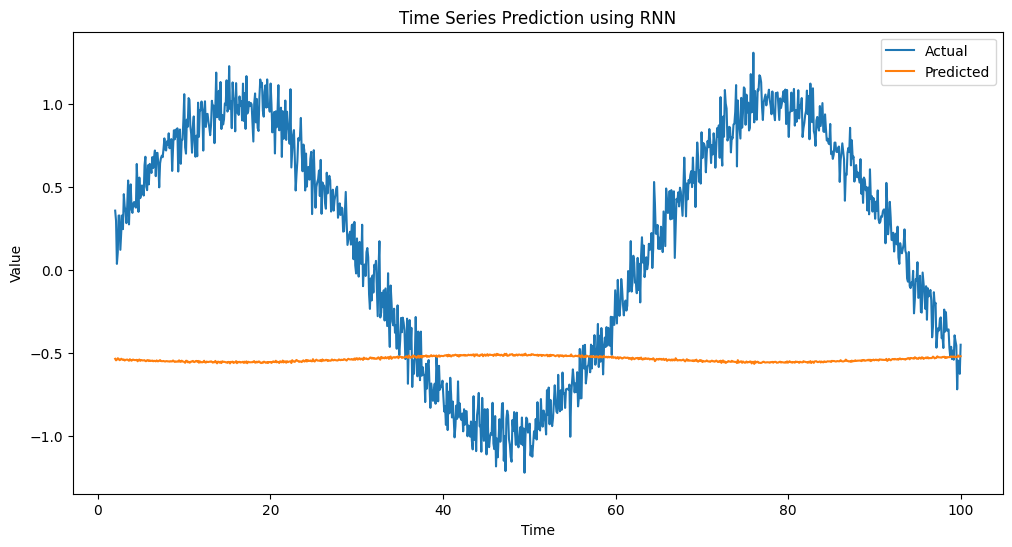

In [18]:
class TimeSeriesRNN(SimpleRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length):
        super().__init__(input_dim, hidden_dim, output_dim)
        self.seq_length = seq_length

    def prepare_data(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            X.append(data[i:i + self.seq_length])
            y.append(data[i + self.seq_length])
        return np.array(X), np.array(y)

    def predict(self, x):
        # Initialize hidden state
        h = np.zeros((self.hidden_dim, 1))
        # Convert input to correct shape for RNN
        x = x.reshape(-1, 1)
        outputs, _ = self.forward(x, h)
        return outputs[-1]

    def forward(self, input_sequence, initial_hidden_state):
        """
        Forward pass through the RNN.
        """
        hidden_state = initial_hidden_state
        outputs = []
        hidden_states = []

        for input_t in input_sequence:
            input_t = input_t.reshape(-1, 1)
            hidden_state = np.tanh(np.dot(self.W_input_hidden, input_t) +
                                np.dot(self.W_hidden_hidden, hidden_state) +
                                self.bias_hidden)
            output_t = np.dot(self.W_hidden_output, hidden_state) + self.bias_output
            outputs.append(output_t)
            hidden_states.append(hidden_state)

        return outputs, hidden_states


    def bptt(self, dh_next, cache, targets):
        """
        Performs backpropagation through time (BPTT) to compute gradients.

        Args:
            dh_next: Gradient of the hidden state from the next time step.
            cache: Cached values from the forward pass.
            targets: List of target output vectors.

        Returns:
            dW_input_hidden: Gradient of input-to-hidden weights.
            dW_hidden_hidden: Gradient of hidden-to-hidden weights.
            dW_hidden_output: Gradient of hidden-to-output weights.
            db_hidden: Gradient of hidden biases.
            db_output: Gradient of output biases.
        """
        inputs, hidden_states, outputs = cache

        dW_input_hidden = np.zeros_like(self.W_input_hidden)
        dW_hidden_hidden = np.zeros_like(self.W_hidden_hidden)
        dW_hidden_output = np.zeros_like(self.W_hidden_output)
        db_hidden = np.zeros_like(self.bias_hidden)
        db_output = np.zeros_like(self.bias_output)

        dh = np.zeros_like(hidden_states[0])

        # Ensure lengths are consistent
        if len(inputs) != len(hidden_states):
            raise ValueError(f"Length mismatch: Inputs length ({len(inputs)}) and Hidden states length ({len(hidden_states)})")
        if len(outputs) != len(inputs):
            raise ValueError(f"Length mismatch: Outputs length ({len(outputs)}) and Inputs length ({len(inputs)})")
        if len(targets) != 1:
            raise ValueError(f"Length mismatch: Targets length ({len(targets)})")

        for t in reversed(range(len(inputs))):
            dy = outputs[t] - targets[0]  # targets is a list with one element
            dW_hidden_output += np.dot(dy, hidden_states[t].T)
            db_output += dy

            dh = np.dot(self.W_hidden_output.T, dy) + dh_next
            dh_raw = (1 - hidden_states[t] ** 2) * dh  # Derivative of tanh
            db_hidden += dh_raw

            # Ensure correct shape for gradients
            dW_input_hidden += np.dot(dh_raw, inputs[t].reshape(1, -1))
            if t > 0:  # To avoid indexing error
                dW_hidden_hidden += np.dot(dh_raw, hidden_states[t - 1].T)

            dh_next = np.dot(self.W_hidden_hidden.T, dh_raw)

        return dW_input_hidden, dW_hidden_hidden, dW_hidden_output, db_hidden, db_output



# Generate sample time series data
t = np.linspace(0, 100, 1000)
data = np.sin(0.1 * t) + np.random.normal(0, 0.1, 1000)

# Initialize and train the RNN
rnn = TimeSeriesRNN(input_dim=1, hidden_dim=50, output_dim=1, seq_length=20)
X, y = rnn.prepare_data(data)

# Train the RNN (simplified)
for epoch in range(100):
    total_loss = 0
    for i in range(len(X)):
        initial_hidden_state = np.zeros((rnn.hidden_dim, 1))  # Initialize hidden state
        outputs, hidden_states = rnn.forward(X[i].reshape(-1, 1), initial_hidden_state)
        loss = np.sum((outputs[-1] - y[i].reshape(-1, 1)) ** 2)
        total_loss += loss

        # Perform backpropagation and update weights
        dh_next = np.zeros_like(hidden_states[0])  # Initialize dh_next
        cache = (X[i].reshape(-1, 1), hidden_states, outputs)  # Pass hidden_states and outputs
        try:
            # Convert y[i] to match the expected shape and length
            gradients = rnn.bptt(dh_next, cache, [y[i].reshape(-1, 1)])
            rnn.update_parameters(gradients)
        except ValueError as e:
            print(f"ValueError: {e}")
            print(f"inputs length: {len(cache[0])}")
            print(f"hidden_states length: {len(cache[1])}")
            print(f"outputs length: {len(cache[2])}")
            print(f"targets length: {len([y[i].reshape(-1, 1)])}")
            raise e

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")


# Make predictions
predictions = [rnn.predict(x.reshape(-1, 1)) for x in X]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t[rnn.seq_length:], data[rnn.seq_length:], label='Actual')
plt.plot(t[rnn.seq_length:], [p[0, 0] for p in predictions], label='Predicted')
plt.legend()
plt.title('Time Series Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


### Variations of RNNs: LSTM

#### Long Short-Term Memory (LSTM) networks are a widely used type of RNN that address the challenge of capturing long-term dependencies more effectively.
#### They achieve this by incorporating gates that regulate the flow of information through the network.

Output shape: (5, 1)
Hidden state shape: (20, 1)
Cell state shape: (20, 1)


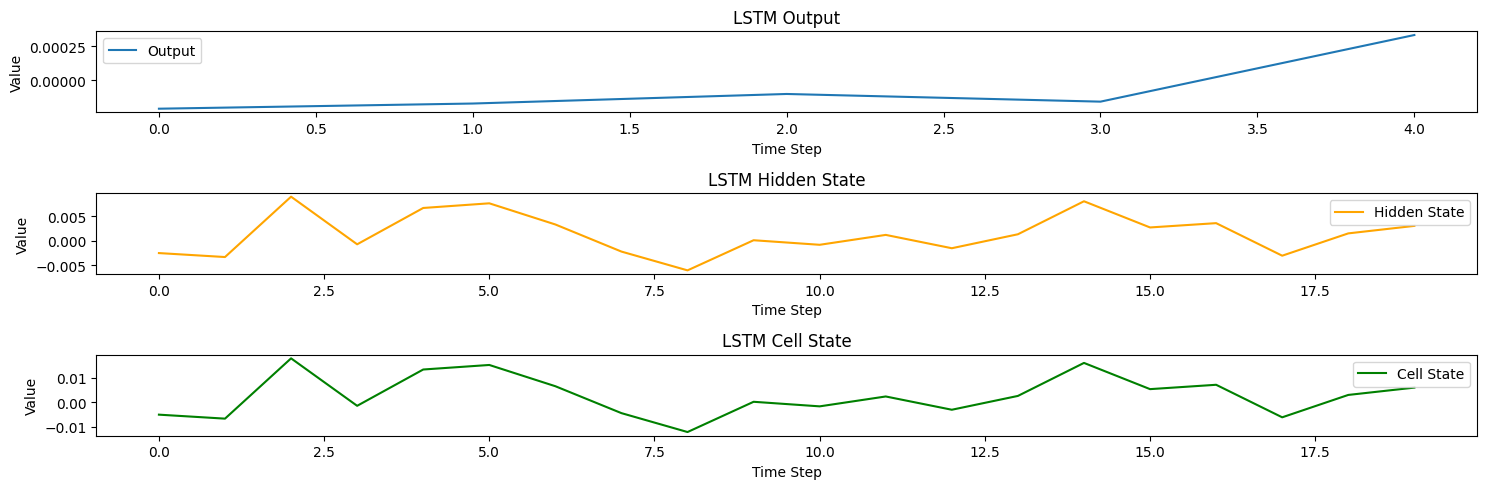

In [11]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size

        # Initialize weights with small random values
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.Wy = np.random.randn(output_size, hidden_size) * 0.01

        # Initialize biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, x, h_prev, c_prev):
        z = np.vstack((h_prev, x))

        # Compute gate values
        f = self._sigmoid(np.dot(self.Wf, z) + self.bf)
        i = self._sigmoid(np.dot(self.Wi, z) + self.bi)
        c_bar = np.tanh(np.dot(self.Wc, z) + self.bc)

        # Update cell state and hidden state
        c = f * c_prev + i * c_bar
        o = self._sigmoid(np.dot(self.Wo, z) + self.bo)
        h = o * np.tanh(c)

        # Compute output
        y = np.dot(self.Wy, h) + self.by

        return y, h, c

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Example usage
lstm = LSTM(input_size=10, hidden_size=20, output_size=5)
x = np.random.rand(10, 1)
h_prev = np.zeros((20, 1))
c_prev = np.zeros((20, 1))
y, h, c = lstm.forward(x, h_prev, c_prev)

print(f"Output shape: {y.shape}")
print(f"Hidden state shape: {h.shape}")
print(f"Cell state shape: {c.shape}")

# Reshape data for plotting
y = y.flatten()
h = h.flatten()
c = c.flatten()

# Plot the output
plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.plot(y, label='Output')
plt.title('LSTM Output')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Plot the hidden state
plt.subplot(3, 1, 2)
plt.plot(h, label='Hidden State', color='orange')
plt.title('LSTM Hidden State')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Plot the cell state
plt.subplot(3, 1, 3)
plt.plot(c, label='Cell State', color='green')
plt.title('LSTM Cell State')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


### GRU (Gated Recurrent Unit)

#### Gated Recurrent Units (GRUs) are a well-known alternative to traditional RNNs.
#### They share similarities with Long Short-Term Memory (LSTM) networks but employ a more streamlined gating mechanism.

In [13]:
class GRU:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim
        self.Wz = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wr = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wh = np.random.randn(hidden_dim, input_dim + hidden_dim) * 0.01
        self.Wy = np.random.randn(output_dim, hidden_dim) * 0.01
        self.bz = np.zeros((hidden_dim, 1))
        self.br = np.zeros((hidden_dim, 1))
        self.bh = np.zeros((hidden_dim, 1))
        self.by = np.zeros((output_dim, 1))

    def forward(self, x, h_prev):
        combined = np.vstack((h_prev, x))
        update_gate = sigmoid(np.dot(self.Wz, combined) + self.bz)
        reset_gate = sigmoid(np.dot(self.Wr, combined) + self.br)
        h_candidate = np.tanh(np.dot(self.Wh, np.vstack((reset_gate * h_prev, x))) + self.bh)
        h_next = (1 - update_gate) * h_prev + update_gate * h_candidate
        output = np.dot(self.Wy, h_next) + self.by
        return output, h_next

# Helper function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Example usage
gru = GRU(input_dim=10, hidden_dim=20, output_dim=5)
x = np.random.randn(10, 1)
h_prev = np.zeros((20, 1))
output, h_next = gru.forward(x, h_prev)

print(f"Output shape: {output.shape}")
print(f"Hidden state shape: {h_next.shape}")


Output shape: (5, 1)
Hidden state shape: (20, 1)


### Bidirectional RNNs

#### Bidirectional RNNs process input sequences in both forward and backward directions,
#### allowing the network to capture context from both past and future

Output shape: (5, 1)
Hidden state shape: (20, 1)


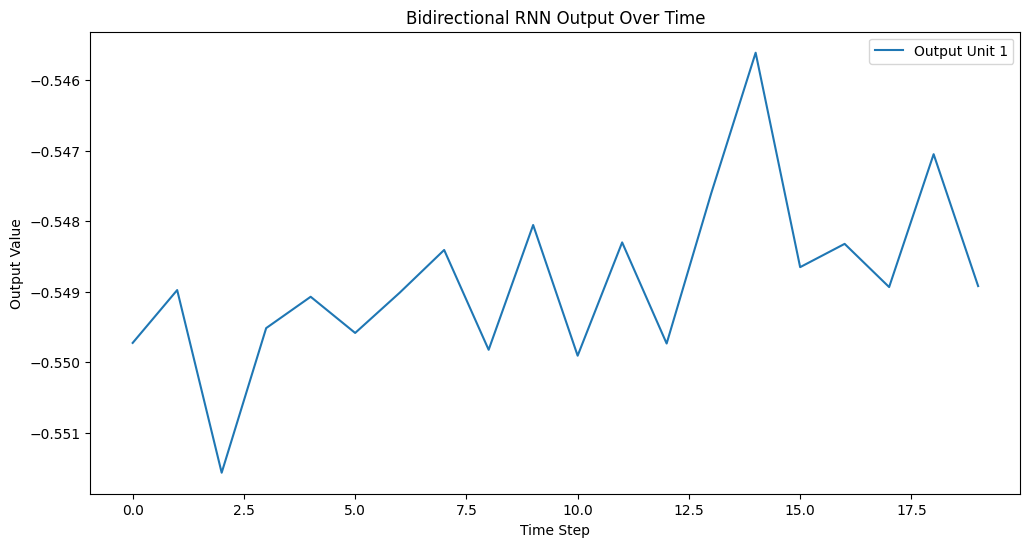

In [14]:
class GRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.Wz = np. random.rand(hidden_size, input_size + hidden_size) * 0.01
        self.Wr = np.random.rand(hidden_size, input_size + hidden_size) * 0.01
        self.Wh = np.random. rand(hidden_size, input_size + hidden_size) * 0.01
        self.Wy = np. random.rand(output_size, hidden_size) * 0.01
        self.bz = np.zeros ((hidden_size, 1))
        self.br = np.zeros ( (hidden_size, 1))
        self.bh = np.zeros ( (hidden_size, 1))
        self.by = np.zeros ( (output_size, 1))

    def forward(self, x, h_prev):
        z = np. row_stack((h_prev, x))
        update = sigmoid(np.dot (self.Wz, z) + self.bz)
        reset = sigmoid (np.dot (self.Wr, z) + self.br)
        h_candidate = np. tanh(np.dot(self.Wh, np.row_stack((reset * h_prev, x))) + self.bh)
        h = (1 - update) * h_prev + update * h_candidate
        y = np.dot (self.Wy, h) + self.by
        return y, h
    
# Helper function
def sigmoid (x):
    return 1 / (1 + np.exp(-x) )

# Example usage
gru = GRU(input_size=10, hidden_size=20, output_size=5)
x = np. random. rand (10, 1)
h_prev = np.zeros ( (20, 1))
y, h = gru. forward(x, h_prev)
print(f"Output shape: {y. shape}")
print(f"Hidden state shape: {h. shape}")

# Plot results
time_steps = np.arange(len(outputs))
output_matrix = np.hstack([o for o in outputs])  # Concatenate outputs for visualization

plt.figure(figsize=(12, 6))
for i in range(output_matrix.shape[0]):
    plt.plot(time_steps, output_matrix[i, :], label=f'Output Unit {i+1}')
plt.legend()
plt.title('Bidirectional RNN Output Over Time')
plt.xlabel('Time Step')
plt.ylabel('Output Value')
plt.show()

### Attention Mechanism

#### Attention mechanisms enable RNNs to selectively focus on various segments of the input sequence for each output,
#### significantly enhancing performance on tasks such as machine translation and speech recognition.

In [17]:
def attention(query, keys, values):
    # Compute dot-product attention
    scores = np.dot(query.T, keys)
    attention_weights = softmax(scores)
    context = np.dot(values, attention_weights.T)
    return context, attention_weights

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

class AttentionRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size  # Save hidden_size in AttentionRNN
        self.rnn = SimpleRNN(input_size, hidden_size, hidden_size)
        self.Wq = np.random.rand(hidden_size, hidden_size) * 0.01
        self.Wk = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Wv = np.random.rand(hidden_size, hidden_size) * 0.01
        self.Wy = np.random.rand(output_size, hidden_size) * 0.01
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs):
        # Initialize the hidden state
        initial_hidden_state = np.zeros((self.hidden_size, 1))
        
        # Get the hidden states from the RNN
        hidden_states, _ = self.rnn.forward(inputs, initial_hidden_state)
        outputs = []

        for t in range(len(inputs)):
            query = np.dot(self.Wq, hidden_states[t])
            keys = np.dot(self.Wk, np.hstack(hidden_states))
            values = np.dot(self.Wv, np.hstack(hidden_states))
            context, _ = attention(query, keys, values)
            output = np.dot(self.Wy, context) + self.by
            outputs.append(output)
        
        return outputs

# Example usage
attn_rnn = AttentionRNN(input_size=10, hidden_size=20, output_size=5)
inputs = [np.random.rand(10, 1) for _ in range(5)]  # 5 time steps
outputs = attn_rnn.forward(inputs)

print(f"Number of outputs: {len(outputs)}")
print(f"Shape of each output: {outputs[0].shape}")

Number of outputs: 5
Shape of each output: (5, 1)
